## Assignment 3B: Recommendation System - Final Code

### Abrar Sultan Hud - a1935666
### Jian Hu - a1916290
### Sayed Umair Mukhtar Bukhari - a1919774

### 0. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from collections import defaultdict
from itertools import combinations
from ast import literal_eval

import time
from tqdm import tqdm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth

warnings.filterwarnings('ignore')



### 1. Read the dataset

In [4]:
df_train = pd.read_csv('./data/Groceries data train.csv')

print("Dataset shape:", df_train.shape)
df_train.head()

Dataset shape: (27000, 7)


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


### 2. Analyse and visualise the data

#### 2.1. Dataset Overview and Summary Statistics

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


The dataset has **27,000 rows and 7 coulmns** which include member ID, date, item description and details like year, month, day, and day of the week.  

In [6]:
df_train.isnull().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

There are **no missing values** in the dataset.

In [7]:
df_train.describe()

,Member_number,year,month,day,day_of_week
count,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000
mean,3002.872667,2014.529037,6.485074,15.744444,3.020852
std,1153.928123,0.499165,3.431239,8.784553,1.987826
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2003.000000,2014.000000,4.000000,8.000000,1.000000
50%,3002.000000,2015.000000,6.000000,16.000000,3.000000
75%,4010.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


From the above output, we can see that the ranges of each columns seems to be reasonable and there are no outliers. 

- The `year` values range from **2014 to 2015**, indicating that the transactions occured from 2014 to 2015. 
- The `Member_number` ranges from **1000 to 5000**, indicating that member IDs are spread across a consistent and bounded range.  
- Other columns such as `month`, `day`, and `day_of_week` also show values within expected limits.

In [8]:
print("Total Transactions:", len(df_train))
print("Total Products (unique):", len(df_train['itemDescription'].unique()))
print("Total Customers (unique):", len(df_train['Member_number'].unique()))
print("Time Range:", df_train['Date'].min(), "to", df_train['Date'].max())
print("Date type:", df_train['Date'].dtypes)

Total Transactions: 27000
Total Products (unique): 167
Total Customers (unique): 3872
Time Range: 1/01/2014 to 9/12/2015
Date type: object


Date is **not a datetime** type, we need to convert it to datetime format.

In [9]:
# Convert the Date variable to datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')
# Check the data types of the variables again
print("Date type:", df_train['Date'].dtypes)
# Check the number of transactions per day
print("\nThe number of transactions per day: \n", df_train.groupby('Date').size().describe())
# check the first 5 rows of the dataset
print(df_train.head())

Date type: datetime64[ns]

The number of transactions per day: 
 count    728.000000
mean      37.087912
std        9.536607
min       11.000000
25%       30.000000
50%       36.000000
75%       43.000000
max       70.000000
dtype: float64
   Member_number       Date  itemDescription  year  month  day  day_of_week
0           3021 2015-01-30      frankfurter  2015      1   30            4
1           1292 2015-10-24             pork  2015     10   24            5
2           4206 2014-04-04  root vegetables  2014      4    4            4
3           4369 2015-08-25           onions  2015      8   25            1
4           1522 2014-07-01          waffles  2014      7    1            1


#### 2.2 Visualize product distribution (product popularity)

Check which products are most common and whether there is a long tail effect `(Kyasar (2023))` (popular products are concentrated). Determine whether you need to filter out low-frequency products (e.g., only keep products that appear more than X times).

In [10]:
# check each itemDescription's frequency
train_top10 = df_train['itemDescription'].value_counts().head(10)
train_bottom10 = df_train['itemDescription'].value_counts().tail(10)
print("The first 10 most common products: \n",train_top10)
print("The last 10 most common products: \n",train_bottom10)

The first 10 most common products: 
 itemDescription
whole milk          1709
other vegetables    1320
rolls/buns          1197
soda                1060
yogurt               928
root vegetables      733
tropical fruit       683
bottled water        666
sausage              637
citrus fruit         560
Name: count, dtype: int64
The last 10 most common products: 
 itemDescription
salad dressing           6
toilet cleaner           5
whisky                   4
make up remover          4
baby cosmetics           3
bags                     3
rubbing alcohol          3
frozen chicken           2
preservation products    1
kitchen utensil          1
Name: count, dtype: int64


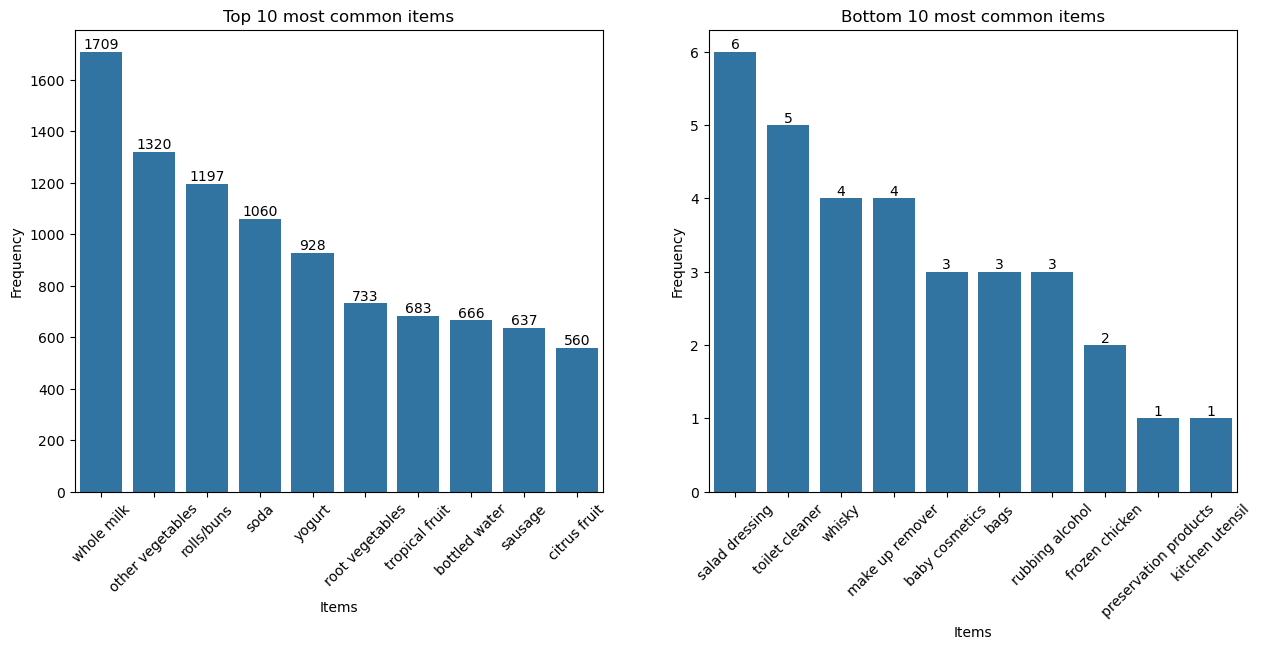

In [12]:
# visualize the distribution of itemDescription for top 10 and bottom 10
def plot_top_bottom_10(train_top10, train_bottom10):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=train_top10.index, y=train_top10.values, ax=ax[0], color='#1f77b4')
    sns.barplot(x=train_bottom10.index, y=train_bottom10.values, ax=ax[1], color='#1f77b4')
    ax[0].set_title('Top 10 most common items')
    ax[1].set_title('Bottom 10 most common items')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('Frequency')
    ax[1].set_xlabel('Items')
    ax[1].set_ylabel('Frequency')
    ax[0].tick_params(axis='x', rotation=45)
    ax[1].tick_params(axis='x', rotation=45)
    # show number on the top of the bar
    for index, value in enumerate(train_top10.values):
        ax[0].text(index, value, str(value), ha='center', va='bottom')
    for index, value in enumerate(train_bottom10.values):
        ax[1].text(index, value, str(value), ha='center', va='bottom')
    plt.show()

plot_top_bottom_10(train_top10, train_bottom10)

**From the top 10 most common products, we can see that:**
* The most frequent product is **whole milk**, which appears **1709** times, followed by other vegetables, rolls/buns, etc.
* Each product in the **top 10** appears **more than 500 times**, which indicates that there are significant **hot-selling products** and are suitable for **frequent item set analysis**.
* The product frequency is **decreasing**, which is in line with the **"long-tail distribution"** hypothesis: a few products have extremely high frequencies, and most products have low frequencies.
* These high-frequency products are likely to constitute frequent item sets (such as "whole milk + yogurt"). I can consider setting **min_support** to 1%-2% of the number of transactions to avoid generating too many **unimportant** item sets.

**From the bottom 10 least common products, we can see that:**
* Some products such as preservation products and kitchen utensil only **appear once**.
* Products that appear **less than 5 times** are basically meaningless in frequent pattern mining, which will bring **sparse** item sets and noise.
* In subsequent preprocessing, I can consider **filtering out** products that appear less than a certain **threshold** (such as 5 or 10 times) to reduce computational complexity and **improve rule quality**.

#### 2.3 Visualize user activity distribution (analyzing shopping frequency)
See if most users only purchase a few times (sparse behavior) and if there are any “super users”.

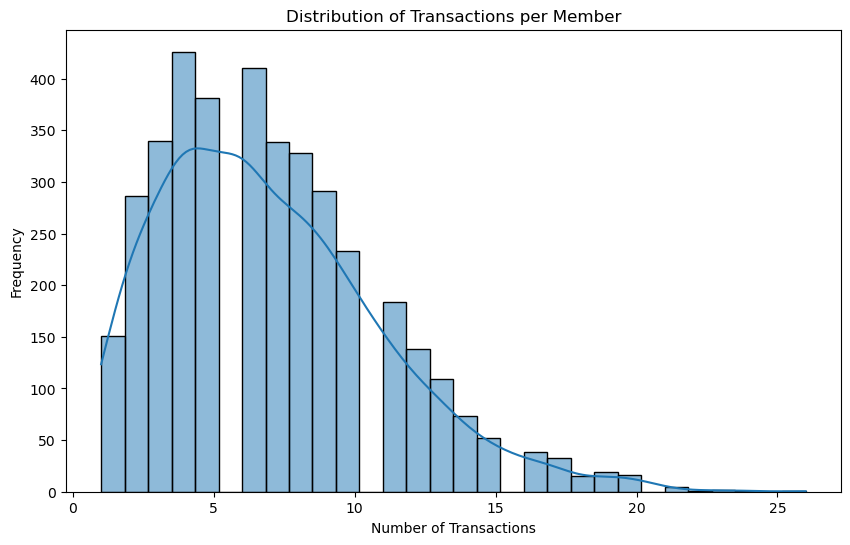

In [13]:
# Distribution of Transactions per Member
def plot_transactions_per_member(df_train):
    # Calculate the number of transactions per member
    transactions_per_member = df_train['Member_number'].value_counts()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(transactions_per_member, bins=30, kde=True)
    plt.title('Distribution of Transactions per Member')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Frequency')
    plt.show()

plot_transactions_per_member(df_train)

**From the customer transaction distribution chart above, we can see that:**
* The number of **transactions** of most members is **less than 10** times, indicating that customers tend to shop **occasionally** or are **non-loyal users**.
* There are a **few high-frequency** transaction users (such as more than 15 times), who may be **loyal customers** or bulk purchase customers.
* The overall data is **biased to the right**, indicating that the data is concentrated in **low-frequency** transactions, and it is necessary to pay attention to the **"tail effect"** in the analysis.

#### 2.4 Analyze trading trends by time (holiday/weekend effects)

Determine whether there are monthly/weekend peaks and decide whether to add time as a mining dimension (e.g. holiday promotion product basket model).

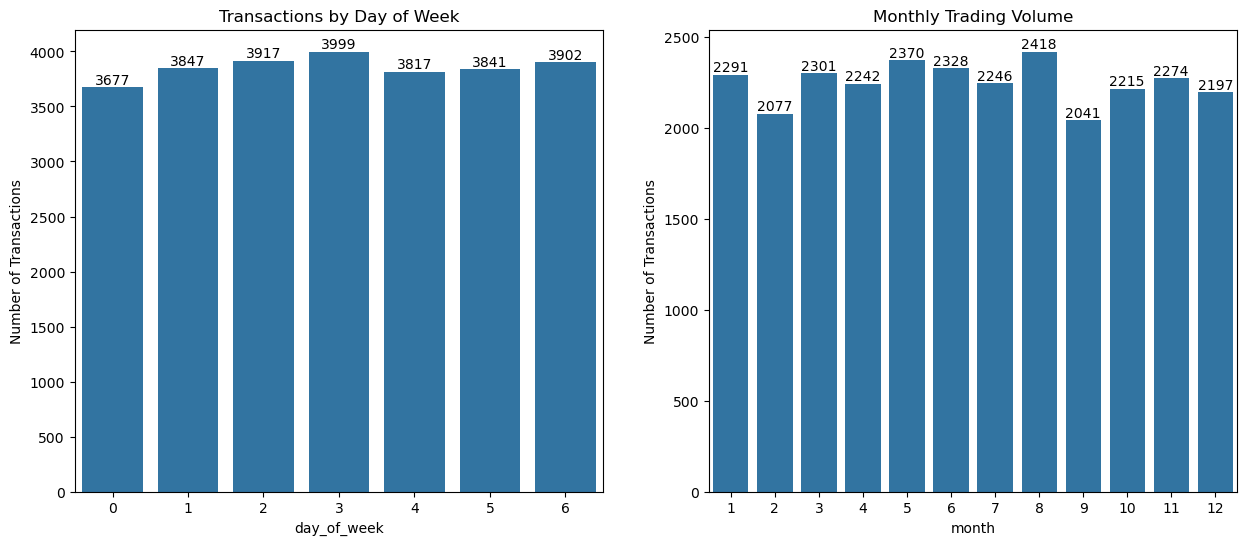

In [15]:
# Monthly Trading Volume and Weekly Trading Volume
def plot_weekly_and_monthly_trading_volume(df_train):
    # Calculate the number of transactions by week and month
    weekly_transactions = df_train.groupby('day_of_week').size()
    monthly_transactions = df_train.groupby('month').size()

    # Plot the weekly and monthly trading volume on one row different subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=weekly_transactions.index, y=weekly_transactions.values, ax=ax[0], color='#1f77b4')
    sns.barplot(x=monthly_transactions.index, y=monthly_transactions.values, ax=ax[1], color='#1f77b4')
    ax[0].set_title('Transactions by Day of Week')
    ax[1].set_title('Monthly Trading Volume')
    ax[0].set_ylabel('Number of Transactions')
    ax[1].set_ylabel('Number of Transactions')
    # show number on the top of the bar
    for index, value in enumerate(weekly_transactions.values):
        ax[0].text(index, value, str(value), ha='center', va='bottom')
    for index, value in enumerate(monthly_transactions.values):
        ax[1].text(index, value, str(value), ha='center', va='bottom')
    plt.show()

plot_weekly_and_monthly_trading_volume(df_train)

**From the Transactions by Day of Week histogram, we can see that:**
* The transaction volume on weekends (Saturdays and Sundays) is slightly higher than that on Mondays, but there is **no obvious peak**.

* The transaction volume reaches its peak on Thursday, and is relatively stable during the week. There is **no typical "weekend shopping peak"**, which shows that user behavior is **not greatly affected** by weekends, and the "day" granularity value of the time dimension is limited.

**From the monthly transaction volume histogram, we can see that:**
* There is an **obvious** transaction peak in **August**, which may be related to the **summer vacation** or promotion, and the transaction is sluggish in February.

* There are **seasonal and holiday effects** at the **monthly** level, and the time dimension has mining value.

But none of this is taken into account in the current analysis as it is not significant different enough to warrant additional complexity in the model.

##### 2.5 Visualize how many items are purchased each time (Transaction "basket" size)

If the basket is small (only 1-2 items), it may not be suitable for association rule mining. If the basket is large enough (3+ items), it can support frequent item set mining.

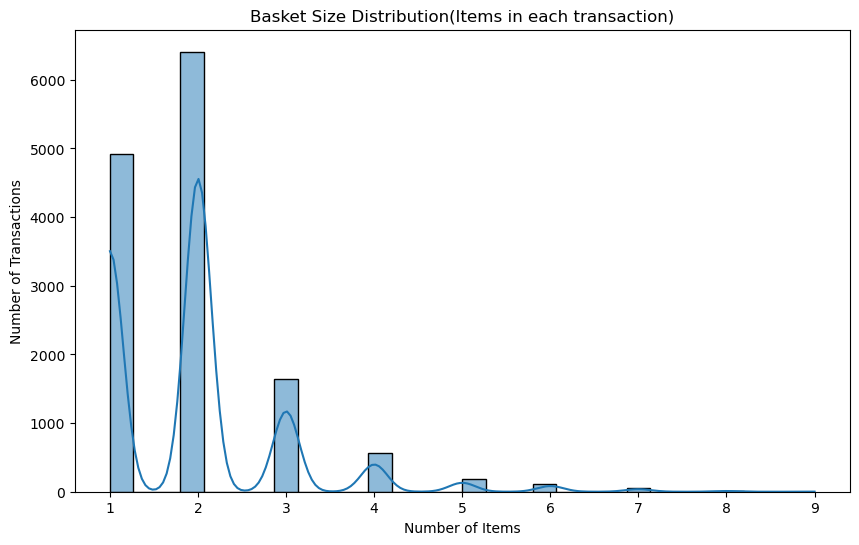

In [16]:
# Brasket size distribution(number of items in each transaction)
def plot_basket_size_distribution(df_train):
    # group by member_number and date, and count the number of items in each transaction
    basket_size = df_train.groupby(['Member_number', 'Date']).size()
    
    # Plot the basket size distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(basket_size, bins=30, kde=True)
    plt.title('Basket Size Distribution(Items in each transaction)')
    plt.xlabel('Number of Items')
    plt.ylabel('Number of Transactions')
    plt.show()
    
plot_basket_size_distribution(df_train)

**The above charts illustrate:**
* Skewed distribution: The basket size distribution is clearly **right-skewed**, that is, most transactions contain **fewer items** (1 to 3), while transactions containing **more items** (more than 4) are **rare**. This indicates that users tend to buy a **small number of items** in a single transaction.
* Main mode: Transactions with **2 items dominate**, which may reflect common purchasing behavior of users (such as buying two items together).
* Long tail effect: Although **most transactions** are concentrated in **1 to 3** items, there are still a few transactions containing 4 to 9 items, showing **transaction diversity**, but the proportion is small.
* Data sparsity: The number of transactions with more than 3 items **drops sharply**, suggesting that the data may be **sparse**, especially when analyzing multi-item combinations (such as association rule mining).

#### 2.6 Visualize product co-occurrence matrix

Visualize co-occurrences matrix and normalized to similarity matrix between items to identify preliminary item associations.

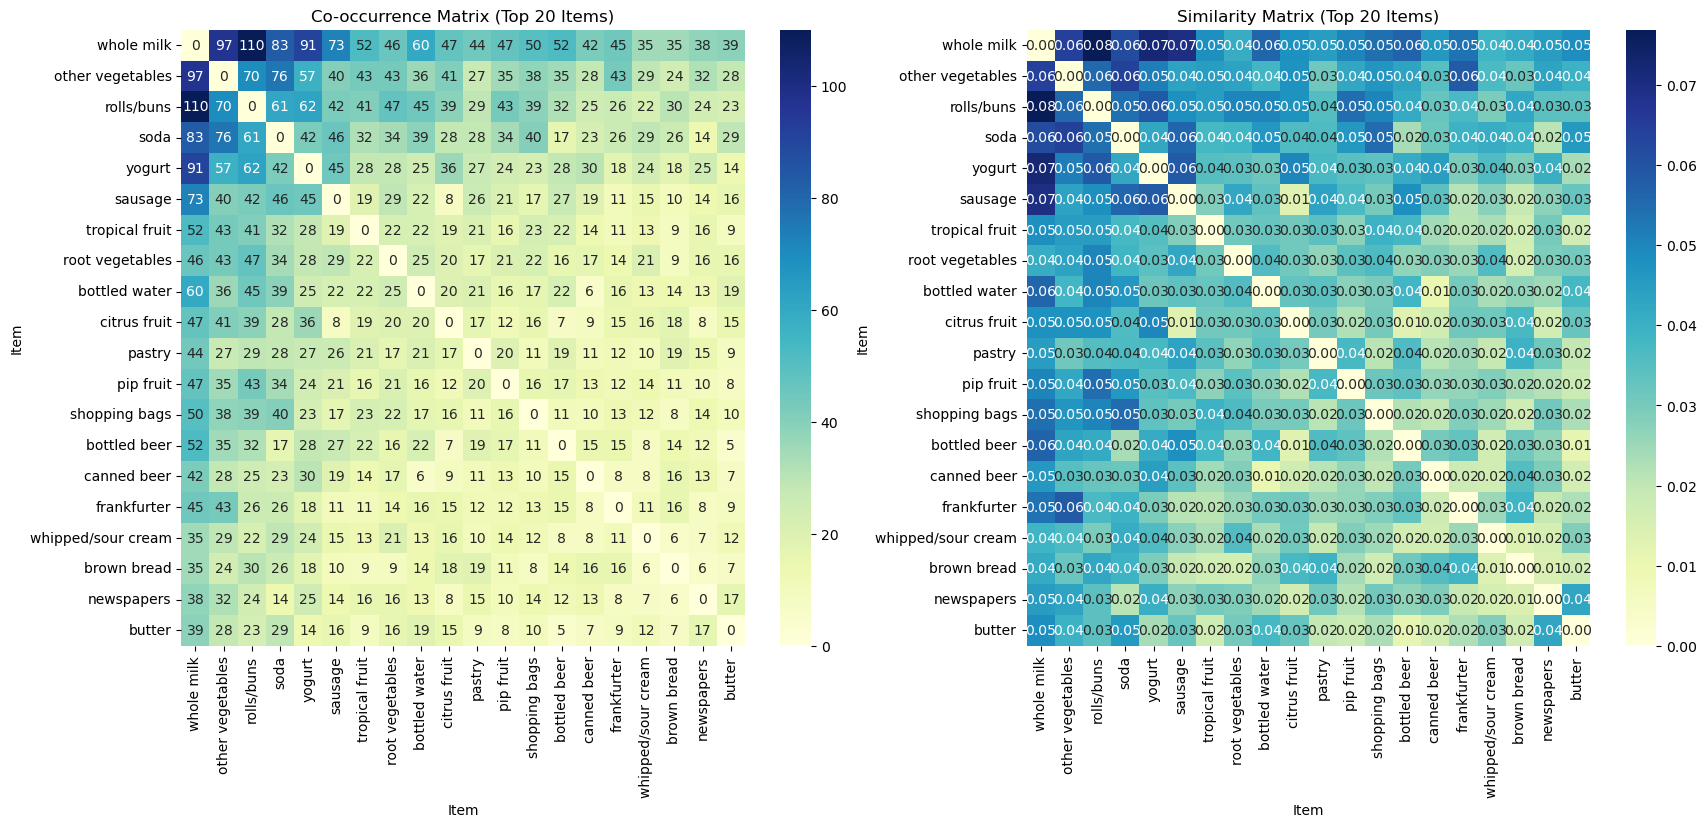

In [17]:
# Each basket: Treat each user's purchase behavior on the same day as a basket (i.e. one transaction)
baskets_df = df_train.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)
# get the number of occurrences of each item
item_counts = df_train['itemDescription'].value_counts().to_dict()
#Count co-occurrences
co_matrix = defaultdict(int)
all_items = sorted(set(df_train['itemDescription'])) # All products that appeared in the dataset

def count_co_occurrences(baskets_df):
    for items in baskets_df:
        unique_items = sorted(set(items)) #sort the items and remove duplicates to ensure consistent order
        for item1, item2 in combinations(unique_items, 2): 
            co_matrix[(item1, item2)] += 1
            co_matrix[(item2, item1)] += 1 #symmetric co-occurrence

    # initialize co-occurrence matrix with zeros
    co_df = pd.DataFrame(0, index=all_items, columns=all_items)

    # fill the matrix with co-occurrence counts
    for (item1, item2), count in co_matrix.items():
        co_df.loc[item1, item2] = count

    return co_df

# construct similarity matrix
def construct_similarity_matrix():
    similarity_df = pd.DataFrame(0.0, index=all_items, columns=all_items)
    for (item1, item2), count in co_matrix.items():
       if item1 in item_counts and item2 in item_counts:
           sim = count / np.sqrt(item_counts[item1] * item_counts[item2])
           similarity_df.loc[item1, item2] = sim
    return similarity_df

# visualize the co-occurrence matrix and similarity matrix(select top 20 items)
def plot_co_occurrence_and_similarity_matrix(co_df, similarity_df):
    top_20_items = co_df.sum().sort_values(ascending=False).head(20).index
    co_df_top20 = co_df.loc[top_20_items, top_20_items]
    similarity_df_top20 = similarity_df.loc[top_20_items, top_20_items]
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(co_df_top20, cmap='YlGnBu', annot=True, fmt='d', ax=ax[0])
    sns.heatmap(similarity_df_top20, cmap='YlGnBu', annot=True, fmt='.2f', ax=ax[1])
    ax[0].set_title('Co-occurrence Matrix (Top 20 Items)')
    ax[1].set_title('Similarity Matrix (Top 20 Items)')
    ax[0].set_xlabel('Item')
    ax[0].set_ylabel('Item')
    ax[1].set_xlabel('Item')
    ax[1].set_ylabel('Item')
    plt.show()

co_df = count_co_occurrences(baskets_df)
similarity_df = construct_similarity_matrix()
plot_co_occurrence_and_similarity_matrix(co_df, similarity_df)

**From the above two matrices, we can conclude that:**

* **High frequency co-occurrence**: **whole milk** is a **core product** and has strong co-occurrence with multiple products.
* **Strong association pairs**: whole milk & rolls/buns, other vegetables & root vegetables, soda & sausage.
* Can be used to **recommend**: People who buy **whole milk** may be **interested** in yogurt and rolls/buns.

### 3. Recommendation System Integration (with Stubbed Inputs)

To test the recommendation system without the full code from Task 1 and 2, we used simple stub methods that return fixed results to check if the system works correctly.
- `FrequentPatternMinerStub`: This stub returns a fixed set of frequent itemsets in pairs and their support counts, simulating the output of a frequent pattern mining algorithm.
- `CollaborativeFilteringModelStub`: This stub returns a fixed set of recommendations for a given member ID, simulating the output of a collaborative filtering model.

In [18]:
# Stub for frequent pattern mining
class FrequentPatternMinerStub:
    def __init__(self, input_data):
        self.input_data = input_data

    def mine_patterns(self):
        """
        Returns dummy frequent item pairs with confidence scores.
        """
        return {
            frozenset({'whole milk', 'rolls/buns'}): 0.0097,
            frozenset({'yogurt', 'whole milk'}): 0.0085,
            frozenset({'soda', 'whole milk'}): 0.0081,
            frozenset({'other vegetables', 'yogurt'}): 0.0073,
            frozenset({'sausage', 'whole milk'}): 0.0064,
        }
    
# Stub for collaborative filtering
class CollaborativeFilteringModelStub:
    def __init__(self, input_data):
        self.input_data = input_data

    def collab_filter(self, user_id):
        """
        Returns dummy CF recommendations for a user.
        """
        dummy_cf = {
            '3050': [('whole milk', 0.80), ('yogurt', 0.6), ('rolls/buns', 0.55)],
            '2625': [('soda', 0.65), ('canned beer', 0.55)],
            '3180': [('rolls/buns', 0.7)],
            '1001': [('other vegetables', 0.75), ('yogurt', 0.5)],
            '2002': [('sausage', 0.6), ('whole milk', 0.55)]
        }
        return dummy_cf.get(str(user_id), [])

In this method, we combine the outputs from pattern mining (Task 1) and collaborative filtering (Task 2) using a weighted scoring system. While the papers provided (Lee et al., 2001) and (Parvatikar et al., 2020) helped me understand the concepts and workflows of each technique, they did not clearly define how to merge them into a unified recommendation.

To achieve this, we followed the hybrid approach described in (Zhou et al., 2010), which uses weighted linear aggregation of scores. We gave more weight to collaborative filtering (0.7) as it tends to be more accurate, and less weight (0.3) to pattern mining, which captures general item associations.

If the user is new and not found in the CF model, the system defaults to top pattern based recommendations to avoid the cold-start issue.

In [19]:
class RecommendationSystemHybrid:
    def __init__(self, pattern_miner: FrequentPatternMinerStub, cf_model: CollaborativeFilteringModelStub):
        self.pattern_miner = pattern_miner
        self.cf_model = cf_model

    def recommend(self, top_k=5, user_id=None):
        """
        Combine pattern-based and CF-based recommendations using weighted scoring.
        """
        pattern_output = self.pattern_miner.mine_patterns()
        cf_output = self.cf_model.collab_filter(user_id)

        combined_scores = {}

        # Weighted contribution from frequent pattern mining
        for item_set, score in pattern_output.items():
            for item in item_set: 
                combined_scores[item] = combined_scores.get(item, 0) + score * 0.3

        # Weighted contribution from collaborative filtering
        for item, score in cf_output:
            combined_scores[item] = combined_scores.get(item, 0) + score * 0.7

        sorted_items = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[:top_k]

# --- Initialize stub models ---
pattern_stub = FrequentPatternMinerStub(df_train)
cf_stub = CollaborativeFilteringModelStub(df_train)
recommender = RecommendationSystemHybrid(pattern_stub, cf_stub)

user_id = 3050 # Existing member number
top_recs = recommender.recommend(top_k=5, user_id=user_id)

print(f" Top {len(top_recs)} Product Recommendations for User ID: {user_id}")
print("-"*50)

for idx, (item, score) in enumerate(top_recs, 1):
    print(f"{idx}. {item:20} | Score: {score:.4f}")

 Top 5 Product Recommendations for User ID: 3050
--------------------------------------------------
1. whole milk           | Score: 0.5698
2. yogurt               | Score: 0.4247
3. rolls/buns           | Score: 0.3879
4. soda                 | Score: 0.0024
5. other vegetables     | Score: 0.0022


In [20]:
user_id = 2000 # New member number
top_recs = recommender.recommend(top_k=5, user_id=user_id)

print(f" Top {len(top_recs)} Product Recommendations for User ID: {user_id}")
print("-"*50)

for idx, (item, score) in enumerate(top_recs, 1):
    print(f"{idx}. {item:20} | Score: {score:.4f}")

 Top 5 Product Recommendations for User ID: 2000
--------------------------------------------------
1. whole milk           | Score: 0.0098
2. yogurt               | Score: 0.0047
3. rolls/buns           | Score: 0.0029
4. soda                 | Score: 0.0024
5. other vegetables     | Score: 0.0022


### 4. Recommendation System Integration

#### 4.1 Pattern Mining

In [21]:
# Each basket: Treat each user's purchase behavior on the same day as a basket (i.e. one transaction)
baskets_df = df_train.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)

# preprocess transactions data
def preprocess_transactions(df): 
    # group by member_number and date, and collect item list
    transactions = baskets_df.values.tolist()
    
    # convert to one-hot encoding
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
    return df_encoded, transactions

df_encoded, transactions = preprocess_transactions(df_train)
df_encoded

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13896,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13897,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13898,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13899,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
class FrequentPatternMiner:
    def __init__(self, min_support=0.005, min_confidence=0.01):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_patterns = None
        self.rules = None
    
    # find frequent patterns
    def find_patterns(self, df_encoded):
        self.frequent_patterns = fpgrowth(df_encoded, 
                                        min_support=self.min_support, 
                                        use_colnames=True)
        return self.frequent_patterns
  
    # generate association rules
    def generate_rules(self):
        self.rules = association_rules(self.frequent_patterns, 
                                     metric="confidence",
                                     min_threshold=self.min_confidence)
        return self.rules
    
    # visualize top N frequent patterns(according to support)
    def visualize_top_frequent_patterns(self, top_n=20):
        if self.frequent_patterns is None or self.frequent_patterns.empty:
            print("No frequent patterns found")
            return

        if not hasattr(self.frequent_patterns, 'support') or not hasattr(self.frequent_patterns, 'itemsets'):
            print("The format of frequent_patterns is not correct")
            return
        
        try:
            # sort the frequent patterns by support in descending order
            top_patterns = self.frequent_patterns.sort_values(by='support', ascending=False).head(top_n)
            
            # convert frozenset to string for plotting
            top_patterns['itemsets_str'] = top_patterns['itemsets'].apply(lambda x: ', '.join(list(x)))

            plt.figure(figsize=(12, max(6, top_n * 0.4))) # adjust height dynamically, minimum height is 6
            bars = plt.barh(top_patterns['itemsets_str'], top_patterns['support'], color='skyblue')
            plt.xlabel('Support')
            plt.ylabel('Frequent Itemsets')
            plt.title(f'Top {top_n} Frequent Itemsets (Sorted by Support)')
            plt.gca().invert_yaxis() # put the highest support at the top
            
            for bar in bars:
                plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                         f'{bar.get_width():.4f}', 
                         va='center', ha='left', fontsize=8, color='black')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error when plotting: {e}")

    def visualize_rules_scatter(self, metric_x='support', metric_y='confidence', color_by='lift', top_n_rules=100):
        """visualize rules scatter plot

        Args:
            metric_x (str): X-axis used metric (e.g. 'support', 'confidence', 'lift').
            metric_y (str): Y-axis used metric.
            color_by (str): The metric used to determine the color of the points (e.g. 'lift', 'support', 'confidence').
            top_n_rules (int, optional): Maximum number of rules to display, sorted by confidence and lift. None shows all.
        """
        if self.rules is None or self.rules.empty:
            print("No association rules generated")
            return

        required_cols = {metric_x, metric_y, color_by, 'antecedents', 'consequents'}
        if not required_cols.issubset(self.rules.columns):
            print(f"Missing required columns: {required_cols}")
            return

        # use a copy to avoid modifying the original data
        rules_to_plot = self.rules.copy() 

        if top_n_rules and top_n_rules < len(rules_to_plot):
            # ensure the columns for sorting exist
            sort_cols = ['confidence', 'lift']
            if not all(col in rules_to_plot.columns for col in sort_cols):
                print(f"Missing required columns: {sort_cols}")
            else:
                rules_to_plot = rules_to_plot.sort_values(by=sort_cols, ascending=[False, False]).head(top_n_rules)

        try:
            plt.figure(figsize=(12, 8))
            
            # according to the value of color_by, determine the size of the point, if the metric is lift, the effect is more obvious
            # also ensure the size of the point is not too large or too small
            if color_by in rules_to_plot.columns:
                point_sizes = rules_to_plot[color_by] * 100 if color_by == 'lift' else rules_to_plot[color_by] * 200 + 20
                point_sizes = point_sizes.clip(10, 500) # limit the range of point size
            else:
                point_sizes = 50 # default size

            scatter = plt.scatter(rules_to_plot[metric_x], rules_to_plot[metric_y], 
                                  alpha=0.6, 
                                  c=rules_to_plot[color_by] if color_by in rules_to_plot.columns else None,
                                  s=point_sizes,
                                  cmap='viridis')
            
            plt.xlabel(metric_x.capitalize())
            plt.ylabel(metric_y.capitalize())
            plt.title(f'Association Rules: {metric_x.capitalize()} vs. {metric_y.capitalize()} ({color_by.capitalize()} as Color/Size)')
            
            if color_by in rules_to_plot.columns:
                cbar = plt.colorbar(scatter) 
                cbar.set_label(color_by.capitalize())
            
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error when plotting: {e}")

In [23]:
pattern_miner = FrequentPatternMiner(min_support=0.001, min_confidence=0.05)

# find frequent patterns
frequent_patterns = pattern_miner.find_patterns(df_encoded)
if frequent_patterns is not None:
    frequent_patterns['itemset_length'] = frequent_patterns['itemsets'].apply(lambda x: len(x))

# save the frequent patterns to a csv file
frequent_patterns.to_csv('./data/frequent_patterns.csv', index=False)

# generate association rules
rules = pattern_miner.generate_rules()
rules = rules.sort_values(by=['support', 'confidence', 'lift'], ascending=[False, False, False])
rules.to_csv('./data/rules.csv', index=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
24,(rolls/buns),(whole milk),0.083519,0.118049,0.007913,0.094746,0.802598,1.0,-0.001946,0.974258,-0.211585,0.040862,-0.026422,0.080889
25,(whole milk),(rolls/buns),0.118049,0.083519,0.007913,0.067032,0.802598,1.0,-0.001946,0.982329,-0.218063,0.040862,-0.017989,0.080889
75,(other vegetables),(whole milk),0.092799,0.118049,0.006978,0.075194,0.636971,1.0,-0.003977,0.953660,-0.385836,0.034227,-0.048591,0.067152
76,(whole milk),(other vegetables),0.118049,0.092799,0.006978,0.059110,0.636971,1.0,-0.003977,0.964195,-0.392546,0.034227,-0.037135,0.067152
3,(yogurt),(whole milk),0.064312,0.118049,0.006546,0.101790,0.862266,1.0,-0.001046,0.981898,-0.145820,0.037234,-0.018436,0.078622


#### 4.2 Collaborative Filtering

In [24]:
class CollaborativeFiltering:
    '''
    Here, we have implemented a user-based collaborative filtering as well as
    pattern based recommendation system.

    Input:
      - Raw Data (CSV)
      - Pattern Data (output of task 1 - CSV)

    Output: 
    - List of Top K recommended items for a member (member_number) for either collaborative filtering (raw data) or patterns (pattern data)
   
    '''
    def __init__(self, data):
        '''
        here, we are loading the raw CSV data and preprocessing it. 
        '''
        self.data = pd.read_csv(data)
        self.data_processing()
    
    def data_processing(self):
        '''
        here, we are creating a utility matrix where is each row is a user (member) and each column is an item
        this is to calculate similarity between users (members).

        '''
        # adding a count column to count the each items bought by a user (member)
        # as our raw dataset contains user id (member bumber) and one item in each row, so initially I am adding 1 to count column
        self.data['count'] = 1

        # creating a utility matrix (basically we are creating a wide form of the dataset)
        # where all the colums are available unique item name (167 items) and rows are the member's ID (3872 members) and 
        # values are the values from count column (summed for a item bought multiple times)
        self.utility_matrix = pd.pivot_table(self.data, index='Member_number', columns='itemDescription', values='count', aggfunc='sum', fill_value=0)

        # coverting the utility matrix (dataframe) to numpy for faster and efficient system
        self.utility_matrix_numpy = self.utility_matrix.to_numpy()

        # mapping member ID's to numpy arrary index
        self.member_id_to_np_index_map = {}
        for i, member_id in enumerate(self.utility_matrix.index):
            self.member_id_to_np_index_map[member_id] = i

        # mapping item decription to numpy index
        self.item_description = self.utility_matrix.columns.to_list()

        # overview of the utility matrix
        return self.utility_matrix
    
   
    def cosine_similarity(self, user_1, user_2):
        '''
        calculating cosine similarity between two users
        '''
        # calculating dot product between two users
        dot_product = np.dot(user_1, user_2)

        # calculating magnitude 
        magnitude_of_vector = np.sqrt(np.sum(user_1 ** 2) * np.sum(user_2 ** 2))

        # cosine similarity
        cos_similarity = dot_product / magnitude_of_vector
        return cos_similarity
    
    def predict_purchase(self, item_index, member_index):
        '''
        here, we are calculating the predition score that indicates the score that a given user will buy a specific item.
        
        This score is the weighted avegrage calculated by using the formula, 

                           similarity(given_user, all_user_who_bought_the_item) * purchase_frequency_of_all_user_who_bought_the_item
        weighted_avg = ------------------------------------------------------------------------------------------------------------------ (division)
                                       sum(similarity(given_user, all_user_who_bought_the_item)) 
      
        '''
        # getting the item column 
        items_each_member = self.utility_matrix_numpy[:, item_index]

        # getting the index of the members who bought this item
        purchesed_item_indeces = np.where(items_each_member != 0)[0]

        # getting the purchase frequency of the members who bought the item
        purchesed_item_count = items_each_member[purchesed_item_indeces]

        # calculating the similarity between the given member and the member who bought the item
        member_similarity = [self.cosine_similarity(self.utility_matrix_numpy[member_index], self.utility_matrix_numpy[i]) for i in purchesed_item_indeces]
        
        # calculating the prediction score (weighted avegrage)
        weighted_avg = np.dot(member_similarity, purchesed_item_count) / np.sum(member_similarity) 
        return weighted_avg

    
    def make_recommendation(self, member_number, recommend_top_k):
        '''
        here, we are making recommending top K items to the member. For this we find the items that user did not 
        bought and then get the prediction score (using predict_purchase method) for those items and select the top K item
        as recommended item.

        '''

        # getting index for member id
        member_index = self.member_id_to_np_index_map[member_number]
        
        # getting the item index that the member have not bought
        item_not_bought_by_member_indeces = np.where(self.utility_matrix_numpy[member_index] == 0)[0]

        weighted_scores = []
        for item_index in item_not_bought_by_member_indeces:
            # getting the prediction score for each item
            predicted_purchase_score = self.predict_purchase(item_index, member_index)
            weighted_scores.append((item_index, predicted_purchase_score))

        # sorting based on prediction scores and selecting the top K items
        top_items_to_recommend = sorted(weighted_scores, key=lambda x: x[1], reverse=True)[:recommend_top_k]

        #  getting the item description
        recommened_items = [(self.item_description[i], score) for i, score in top_items_to_recommend]
        return recommened_items    

    def make_recommendation_from_pattern(self, patterns, member_number, recommend_top_k):
        '''
        here, we are making item recommendation based on the frequent pattern for a given user.

        For this method, first we indentify all  the items that the user bought. Then we loop through all the frequent patterns (rules), and make recommendation 
        if the antecedent is a subset of the user's already bought items. Here, the items in (consequent - item_bought_by_user) items not bought 
        for the related antecedent is choosen for recommandation. For making recommendation we select top K items based on their lift score.
        '''
        # loading the pattern data
        self.patterns = pd.read_csv(patterns)

        # getting the items for the give user
        user_item_list = self.utility_matrix.loc[member_number]

        # getting the items user already bought
        item_bought_by_user = user_item_list[user_item_list != 0].index.tolist()

        # converting the list to frozentset for comparison
        item_bought_by_user = frozenset(item_bought_by_user)

        recommended_item = []
        for row_index, row in self.patterns.iterrows():
            # getting the antecedent and consequent of a rule 
            antecedent = self.str_to_frozenset(row['antecedents'])
            consequent = self.str_to_frozenset(row['consequents'])

            # getting the metric values 
            lift = row['lift']
            support = row['support']
            confidence = row['confidence']

            # making recommendation 
            if antecedent.issubset(item_bought_by_user):
                # getting the items that user has not bought
                item_not_bought = consequent - item_bought_by_user
                for item in item_not_bought:
                    # dict for each item to avoid reference issues
                    temp_dict = {
                        'item': item,
                        'lift': lift,
                        'support': support,
                        'confidence': confidence
                    }
                    recommended_item.append(temp_dict)

        # sorting the items based on lift score, to recommend the top K items
        recommended_item.sort(key=lambda x: x['lift'], reverse=True)

        # filtering out the duplicate items
        unique_items = []
        seen_items = set()
        for item in recommended_item:
            if item['item'] not in seen_items:
                unique_items.append((item['item'], item['lift']))  # return item and lift
                seen_items.add(item['item'])

        # return K or less than K items
        return unique_items[:recommend_top_k]
    
    def cold_start(self, recommend_top_k):
        '''
        make recommendation for users not in the training data (new users). Here we will recommend the top K most frequent item
        in the training set for the new member.
        '''
        # getting item frequency
        item_count = self.data['itemDescription'].value_counts()
        
        # getting top K item description for recommendation
        frequent_item = item_count.index.to_list()[:recommend_top_k]
        return [(item, 1.0) for item in frequent_item]    # Dummy lift score as 1.0 for cold start users

    def str_to_frozenset(self, str):
        '''
        convert string to frozenset for pattern data
        '''
        # removing getting the itemset inside frozenset() string
        items_str = str[len("frozenset("):-1]

        # parses the string literal to set
        item_set = literal_eval(items_str)

        # converting the set to frozen set and return 
        return frozenset(item_set)

In [25]:
# instantiating class
data = './data/Groceries data train.csv'
cf_recommend = CollaborativeFiltering(data=data)

# overview of the utility matrix
cf_recommend.data_processing()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,2,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# making recommendation for a user (from raw data)
member_number = 1000
recommend_item = 5

# making recommendation
cf_recommend.make_recommendation(member_number, recommend_item)

[('whole milk', 1.2693628181436285),
 ('other vegetables', 1.1929853997789077),
 ('rolls/buns', 1.163543242520402),
 ('root vegetables', 1.1146178994158111),
 ('tropical fruit', 1.092933437019861)]

In [27]:
# making recommendation for a user (from pattern)
pattern = './data/rules.csv'
member_number = 1000
recommend_item = 5

# making recommendation from pattern
cf_recommend.make_recommendation_from_pattern(pattern, member_number, recommend_item)

[('whole milk', 0.983127121098946),
 ('rolls/buns', 0.8303630095940588),
 ('other vegetables', 0.7951200421464589)]

#### 4.3 Recommendation System - Integration

In [28]:
class RecommendationSystem:
    def __init__(self, cf_model, pattern_file: str):
        """
        Initialize the hybrid recommendation system.

        :param cf_model: Instance of CollaborativeFiltering class
        :param pattern_file: Path to CSV file with pattern mining rules (Task 1 output)
        """
        self.cf_model = cf_model
        self.pattern_file = pattern_file

    def recommend(self, member_number, top_k=10, is_pattern_used=True):
        """
        Combine collaborative filtering and pattern mining results using weighted scoring.

        :param member_number: Member number (user ID)
        :param top_k: Number of recommendations to return
        :return: List of (item, score) tuples
        """
        if member_id not in self.cf_model.member_id_to_np_index_map:
            print(f"[Cold Start] User {member_id} is new. Recommending top-{top_k} popular items.")
            return self.cf_model.cold_start(top_k)
        
        # Get collaborative filtering recommendations
        cf_recs = self.cf_model.make_recommendation(member_number, top_k)
        cf_dict = dict(cf_recs)

        if not is_pattern_used:
            # If pattern mining is not used, return CF results directly
            sorted_cf = sorted(cf_dict.items(), key=lambda x: x[1], reverse=True)
            return sorted_cf[:top_k]
        
        # Pattern mining recommendations
        pattern_recs = self.cf_model.make_recommendation_from_pattern(
            self.pattern_file, member_number, top_k
        )
        pattern_dict = dict(pattern_recs)

        # Normalize and combine
        combined_scores = {}
        max_cf = max(cf_dict.values()) if cf_dict else 1
        max_pat = max(pattern_dict.values()) if pattern_dict else 1

        for item, score in cf_dict.items():
            combined_scores[item] = combined_scores.get(item, 0) + (score / max_cf) * 0.7

        for item, score in pattern_dict.items():
            combined_scores[item] = combined_scores.get(item, 0) + (score / max_pat) * 0.3

        sorted_recs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:top_k]


pattern_file = './data/rules.csv'       # Task 1 output
data_train_path = './data/Groceries data train.csv'  # Task 2 input
cf_model = CollaborativeFiltering(data=data_train_path)
recommender = RecommendationSystem(cf_model, pattern_file)

member_id = 1000
top_k = 10
top_recommendations = recommender.recommend(member_id, top_k=top_k, is_pattern_used=True)

print(f" Top {len(top_recommendations)} Product Recommendations for User ID: {member_id}")
print("-"*50)

for idx, (item, score) in enumerate(top_recommendations, 1):
    print(f"{idx}. {item:20}")

 Top 10 Product Recommendations for User ID: 1000
--------------------------------------------------
1. whole milk          
2. other vegetables    
3. rolls/buns          
4. root vegetables     
5. tropical fruit      
6. pip fruit           
7. bottled beer        
8. whipped/sour cream  
9. bottled water       
10. citrus fruit        


### 5. Evaluation

#### 5.1 Evaluation Metrics

The evaluation metrics used to assess the performance of the recommendation system are (10 metrics to evaluate recommender and ranking systems, 2025): 

- ***Reciporcal Rank (RR)*** Measures the position of the first relevant item in the recommended list. A lower score means the relevant item appears later. The score is calculated as the reciprocal of the rank of the first relevant item.
- ***Hit@K***: Identifies whether at least one relevant item is present in the top K recommendations. It is a binary metric that indicates whether the recommendation was successful or not.
- ***Precision@K***: It shows the number of recommended items that are relevant to the user. It is computed as the number of relevant items divided by K.
- ***Average Precision@K***: It stands for the average precision of all meaningful items in the list of the top K recommendations. Precision is found by dividing the total of all precision scores in relevant positions by the total number of relevant items.

In [29]:
def reciprocal_rank(recommended, relevant):
    for i, item in enumerate(recommended):
        if item in relevant:
            return 1 / (i + 1)
    return 0


def hit_at_k(recommended, relevant, k):
    return int(bool(set(recommended[:k]) & set(relevant)))


def precision_at_k(recommended, relevant, k):
    top_k = recommended[:k]
    return len(set(top_k) & set(relevant)) / k


def average_precision_at_k(recommended, relevant, k):
    hits = 0
    score = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(relevant), k) if relevant else 0

#### 5.2 Evaluation of Recommendations with Frequent Patterns

In [ ]:
test_df = pd.read_csv('./data/Groceries data test.csv')

# Initialize model
cf_recommender = CollaborativeFiltering(data='./data/Groceries data train.csv')
recommender = RecommendationSystem(cf_recommender, pattern_file='./data/rules.csv')

# Evaluation setup
evaluation_results = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    member_id = row['Member_number']
    true_item = row['itemDescription']
    relevant = [true_item]

    start_time = time.time()
    recommendations = recommender.recommend(member_id, top_k=10, is_pattern_used=True)    # Calculating recommendations with patterns
    end_time = time.time()

    recommended_items = [item for item, _ in recommendations]
    elapsed_time = end_time - start_time

    rr = reciprocal_rank(recommended_items, relevant)
    hit = hit_at_k(recommended_items, relevant, k=10)
    precision = precision_at_k(recommended_items, relevant, k=10)
    ap = average_precision_at_k(recommended_items, relevant, k=10)

    evaluation_results.append({
        'member_id': member_id,
        'precision@k': precision,
        'hit@k': hit,
        'ap@k': ap,
        'rr': rr,
        'time': elapsed_time
    })

  2%|▏         | 205/11765 [01:02<57:21,  3.36it/s]  

[Cold Start] User 3858 is new. Recommending top-10 popular items.


  2%|▏         | 207/11765 [01:03<47:02,  4.10it/s]

[Cold Start] User 4590 is new. Recommending top-10 popular items.


  7%|▋         | 856/11765 [04:26<54:12,  3.35it/s]  

[Cold Start] User 1745 is new. Recommending top-10 popular items.


  9%|▉         | 1099/11765 [05:47<59:31,  2.99it/s]  

[Cold Start] User 2417 is new. Recommending top-10 popular items.


 10%|█         | 1203/11765 [06:23<1:00:50,  2.89it/s]

[Cold Start] User 4472 is new. Recommending top-10 popular items.


 13%|█▎        | 1488/11765 [08:00<57:21,  2.99it/s]  

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 13%|█▎        | 1511/11765 [08:08<1:02:50,  2.72it/s]

[Cold Start] User 1626 is new. Recommending top-10 popular items.


 15%|█▍        | 1728/11765 [09:22<1:03:32,  2.63it/s]

[Cold Start] User 1096 is new. Recommending top-10 popular items.


 15%|█▌        | 1770/11765 [09:36<53:56,  3.09it/s]  

[Cold Start] User 2826 is new. Recommending top-10 popular items.


 15%|█▌        | 1816/11765 [09:52<54:19,  3.05it/s]

[Cold Start] User 2826 is new. Recommending top-10 popular items.


 16%|█▌        | 1889/11765 [10:17<59:46,  2.75it/s]  

[Cold Start] User 3994 is new. Recommending top-10 popular items.


 17%|█▋        | 1951/11765 [10:39<58:23,  2.80it/s]  

[Cold Start] User 4639 is new. Recommending top-10 popular items.


 21%|██▏       | 2517/11765 [13:55<55:36,  2.77it/s]  

[Cold Start] User 1250 is new. Recommending top-10 popular items.


 25%|██▍       | 2885/11765 [16:01<53:58,  2.74it/s]  

[Cold Start] User 2668 is new. Recommending top-10 popular items.


 33%|███▎      | 3841/11765 [21:24<42:00,  3.14it/s]  

[Cold Start] User 1963 is new. Recommending top-10 popular items.


 34%|███▍      | 4019/11765 [22:26<54:24,  2.37it/s]  

[Cold Start] User 2304 is new. Recommending top-10 popular items.


 36%|███▌      | 4209/11765 [24:04<1:18:51,  1.60it/s]

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 40%|███▉      | 4648/11765 [28:32<38:27,  3.08it/s]   

[Cold Start] User 4447 is new. Recommending top-10 popular items.


 46%|████▋     | 5466/11765 [33:02<33:17,  3.15it/s]

[Cold Start] User 3858 is new. Recommending top-10 popular items.


 47%|████▋     | 5561/11765 [33:29<29:30,  3.50it/s]

[Cold Start] User 3362 is new. Recommending top-10 popular items.


 47%|████▋     | 5566/11765 [33:31<27:48,  3.72it/s]

[Cold Start] User 1963 is new. Recommending top-10 popular items.


 49%|████▊     | 5733/11765 [34:20<28:54,  3.48it/s]

[Cold Start] User 1626 is new. Recommending top-10 popular items.


 50%|████▉     | 5840/11765 [34:54<44:06,  2.24it/s]

[Cold Start] User 4307 is new. Recommending top-10 popular items.


 51%|█████     | 5990/11765 [37:02<33:14,  2.90it/s]   

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 51%|█████     | 6011/11765 [37:08<32:00,  3.00it/s]

[Cold Start] User 4472 is new. Recommending top-10 popular items.


 53%|█████▎    | 6224/11765 [38:19<31:04,  2.97it/s]

[Cold Start] User 4904 is new. Recommending top-10 popular items.


 54%|█████▍    | 6330/11765 [38:55<28:52,  3.14it/s]

[Cold Start] User 4639 is new. Recommending top-10 popular items.


 54%|█████▍    | 6380/11765 [39:11<29:30,  3.04it/s]

[Cold Start] User 3994 is new. Recommending top-10 popular items.


 54%|█████▍    | 6400/11765 [39:17<29:55,  2.99it/s]

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 55%|█████▌    | 6476/11765 [39:44<29:37,  2.98it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 56%|█████▋    | 6639/11765 [40:40<24:57,  3.42it/s]

[Cold Start] User 1695 is new. Recommending top-10 popular items.


 58%|█████▊    | 6789/11765 [41:24<23:33,  3.52it/s]

[Cold Start] User 2304 is new. Recommending top-10 popular items.


 62%|██████▏   | 7288/11765 [44:17<26:07,  2.86it/s]

[Cold Start] User 4905 is new. Recommending top-10 popular items.


 64%|██████▍   | 7547/11765 [45:46<23:44,  2.96it/s]

[Cold Start] User 4904 is new. Recommending top-10 popular items.


 65%|██████▌   | 7650/11765 [46:23<28:07,  2.44it/s]

[Cold Start] User 1555 is new. Recommending top-10 popular items.


 68%|██████▊   | 7949/11765 [48:03<20:59,  3.03it/s]

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 71%|███████   | 8342/11765 [50:20<30:07,  1.89it/s]

[Cold Start] User 1096 is new. Recommending top-10 popular items.


 72%|███████▏  | 8468/11765 [51:11<17:06,  3.21it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 72%|███████▏  | 8478/11765 [51:14<18:09,  3.02it/s]

[Cold Start] User 4905 is new. Recommending top-10 popular items.


 77%|███████▋  | 9011/11765 [53:52<13:20,  3.44it/s]

[Cold Start] User 1695 is new. Recommending top-10 popular items.


 77%|███████▋  | 9095/11765 [54:16<13:01,  3.41it/s]

[Cold Start] User 4447 is new. Recommending top-10 popular items.


 79%|███████▉  | 9285/11765 [55:11<12:14,  3.37it/s]

[Cold Start] User 2668 is new. Recommending top-10 popular items.


 80%|███████▉  | 9379/11765 [55:38<11:44,  3.38it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 81%|████████  | 9476/11765 [56:06<11:22,  3.36it/s]

[Cold Start] User 4590 is new. Recommending top-10 popular items.


 81%|████████  | 9513/11765 [56:21<18:55,  1.98it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 83%|████████▎ | 9751/11765 [57:34<09:48,  3.42it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 86%|████████▌ | 10067/11765 [59:07<08:20,  3.39it/s]

[Cold Start] User 1255 is new. Recommending top-10 popular items.


 86%|████████▌ | 10144/11765 [59:29<08:40,  3.12it/s]

[Cold Start] User 4307 is new. Recommending top-10 popular items.


 88%|████████▊ | 10312/11765 [1:02:59<07:33,  3.20it/s]   

[Cold Start] User 2844 is new. Recommending top-10 popular items.


 90%|█████████ | 10592/11765 [1:04:23<05:49,  3.36it/s]

[Cold Start] User 1745 is new. Recommending top-10 popular items.


 93%|█████████▎| 11000/11765 [1:06:23<03:47,  3.36it/s]

[Cold Start] User 1555 is new. Recommending top-10 popular items.


 94%|█████████▍| 11043/11765 [1:06:36<03:40,  3.27it/s]

[Cold Start] User 1250 is new. Recommending top-10 popular items.


 95%|█████████▍| 11139/11765 [1:07:04<03:05,  3.38it/s]

[Cold Start] User 1255 is new. Recommending top-10 popular items.


 95%|█████████▌| 11191/11765 [1:07:19<02:59,  3.20it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 96%|█████████▌| 11267/11765 [1:08:03<04:14,  1.96it/s]

[Cold Start] User 2417 is new. Recommending top-10 popular items.


 97%|█████████▋| 11452/11765 [1:09:00<01:33,  3.34it/s]

[Cold Start] User 2844 is new. Recommending top-10 popular items.


 98%|█████████▊| 11558/11765 [1:09:31<01:02,  3.31it/s]

[Cold Start] User 3362 is new. Recommending top-10 popular items.


 98%|█████████▊| 11567/11765 [1:09:34<00:56,  3.50it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


100%|██████████| 11765/11765 [1:10:31<00:00,  2.78it/s]


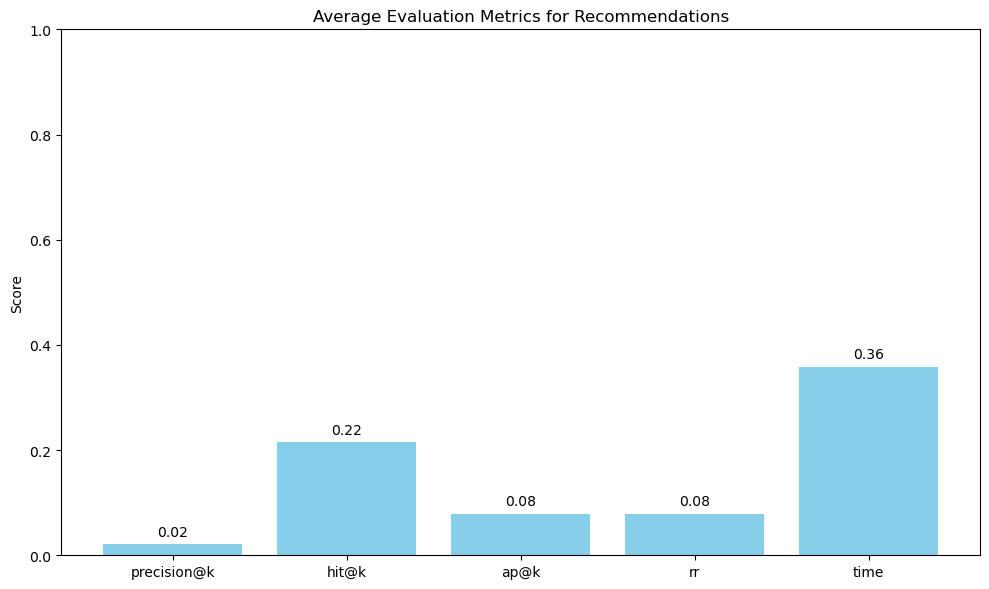

In [ ]:
evaluation_df = pd.DataFrame(evaluation_results)
average_scores = evaluation_df[['precision@k', 'hit@k', 'ap@k', 'rr', 'time']].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(average_scores.index, average_scores.values, color='skyblue')
plt.title("Average Evaluation Metrics for Recommendations (with Patterns)")
plt.ylabel("Score")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 5.3 Evaluation of Recommendations without Frequent Patterns

In [70]:
evaluation_results_no_pattern = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    member_id = row['Member_number']
    true_item = row['itemDescription']
    relevant = [true_item]

    start_time = time.time()
    recommendations = recommender.recommend(
        member_id, top_k=10, is_pattern_used=False  # ← now without patterns
    )
    end_time = time.time()

    recommended_items = [item for item, _ in recommendations]
    elapsed_time = end_time - start_time

    rr = reciprocal_rank(recommended_items, relevant)
    hit = hit_at_k(recommended_items, relevant, k=10)
    precision = precision_at_k(recommended_items, relevant, k=10)
    ap = average_precision_at_k(recommended_items, relevant, k=10)

    evaluation_results_no_pattern.append({
        'member_id': member_id,
        'precision@k': precision,
        'hit@k': hit,
        'ap@k': ap,
        'rr': rr,
        'time': elapsed_time
    })

  2%|▏         | 205/11765 [00:58<52:59,  3.64it/s]  

[Cold Start] User 3858 is new. Recommending top-10 popular items.


  2%|▏         | 207/11765 [00:59<43:21,  4.44it/s]

[Cold Start] User 4590 is new. Recommending top-10 popular items.


  7%|▋         | 856/11765 [20:16<1:25:32,  2.13it/s]   

[Cold Start] User 1745 is new. Recommending top-10 popular items.


  9%|▉         | 1099/11765 [22:04<1:08:43,  2.59it/s]

[Cold Start] User 2417 is new. Recommending top-10 popular items.


 10%|█         | 1203/11765 [22:39<1:01:24,  2.87it/s]

[Cold Start] User 4472 is new. Recommending top-10 popular items.


 13%|█▎        | 1488/11765 [24:19<55:08,  3.11it/s]  

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 13%|█▎        | 1511/11765 [24:27<1:06:15,  2.58it/s]

[Cold Start] User 1626 is new. Recommending top-10 popular items.


 15%|█▍        | 1728/11765 [25:38<53:16,  3.14it/s]  

[Cold Start] User 1096 is new. Recommending top-10 popular items.


 15%|█▌        | 1770/11765 [25:51<50:57,  3.27it/s]

[Cold Start] User 2826 is new. Recommending top-10 popular items.


 15%|█▌        | 1816/11765 [26:06<52:26,  3.16it/s]

[Cold Start] User 2826 is new. Recommending top-10 popular items.


 16%|█▌        | 1889/11765 [26:30<55:34,  2.96it/s]  

[Cold Start] User 3994 is new. Recommending top-10 popular items.


 17%|█▋        | 1951/11765 [26:50<54:03,  3.03it/s]

[Cold Start] User 4639 is new. Recommending top-10 popular items.


 21%|██▏       | 2517/11765 [29:53<52:00,  2.96it/s]  

[Cold Start] User 1250 is new. Recommending top-10 popular items.


 25%|██▍       | 2885/11765 [31:56<48:18,  3.06it/s]  

[Cold Start] User 2668 is new. Recommending top-10 popular items.


 33%|███▎      | 3841/11765 [38:54<41:57,  3.15it/s]   

[Cold Start] User 1963 is new. Recommending top-10 popular items.


 34%|███▍      | 4019/11765 [39:54<44:58,  2.87it/s]

[Cold Start] User 2304 is new. Recommending top-10 popular items.


 36%|███▌      | 4209/11765 [41:00<44:28,  2.83it/s]  

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 40%|███▉      | 4648/11765 [43:26<33:29,  3.54it/s]

[Cold Start] User 4447 is new. Recommending top-10 popular items.


 46%|████▋     | 5466/11765 [47:20<32:02,  3.28it/s]

[Cold Start] User 3858 is new. Recommending top-10 popular items.


 47%|████▋     | 5561/11765 [47:47<30:02,  3.44it/s]

[Cold Start] User 3362 is new. Recommending top-10 popular items.


 47%|████▋     | 5566/11765 [47:48<29:14,  3.53it/s]

[Cold Start] User 1963 is new. Recommending top-10 popular items.


 49%|████▊     | 5733/11765 [48:38<27:59,  3.59it/s]

[Cold Start] User 1626 is new. Recommending top-10 popular items.


 50%|████▉     | 5840/11765 [49:10<27:59,  3.53it/s]

[Cold Start] User 4307 is new. Recommending top-10 popular items.


 51%|█████     | 5990/11765 [49:58<32:11,  2.99it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 51%|█████     | 6011/11765 [50:05<31:15,  3.07it/s]

[Cold Start] User 4472 is new. Recommending top-10 popular items.


 53%|█████▎    | 6224/11765 [51:19<37:39,  2.45it/s]

[Cold Start] User 4904 is new. Recommending top-10 popular items.


 54%|█████▍    | 6330/11765 [51:56<29:30,  3.07it/s]

[Cold Start] User 4639 is new. Recommending top-10 popular items.


 54%|█████▍    | 6380/11765 [52:13<30:41,  2.92it/s]

[Cold Start] User 3994 is new. Recommending top-10 popular items.


 54%|█████▍    | 6400/11765 [52:20<30:21,  2.95it/s]

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 55%|█████▌    | 6476/11765 [52:46<33:14,  2.65it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 56%|█████▋    | 6639/11765 [53:40<30:09,  2.83it/s]

[Cold Start] User 1695 is new. Recommending top-10 popular items.


 58%|█████▊    | 6789/11765 [54:28<24:53,  3.33it/s]

[Cold Start] User 2304 is new. Recommending top-10 popular items.


 62%|██████▏   | 7288/11765 [57:08<24:17,  3.07it/s]

[Cold Start] User 4905 is new. Recommending top-10 popular items.


 64%|██████▍   | 7547/11765 [58:29<20:31,  3.43it/s]

[Cold Start] User 4904 is new. Recommending top-10 popular items.


 65%|██████▌   | 7650/11765 [58:58<18:56,  3.62it/s]

[Cold Start] User 1555 is new. Recommending top-10 popular items.


 68%|██████▊   | 7949/11765 [1:00:21<17:17,  3.68it/s]

[Cold Start] User 1568 is new. Recommending top-10 popular items.


 71%|███████   | 8342/11765 [1:02:15<15:44,  3.62it/s]

[Cold Start] User 1096 is new. Recommending top-10 popular items.


 72%|███████▏  | 8468/11765 [1:02:50<15:17,  3.60it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


 72%|███████▏  | 8478/11765 [1:02:53<15:05,  3.63it/s]

[Cold Start] User 4905 is new. Recommending top-10 popular items.


 77%|███████▋  | 9011/11765 [1:05:25<12:48,  3.59it/s]

[Cold Start] User 1695 is new. Recommending top-10 popular items.


 77%|███████▋  | 9095/11765 [1:05:48<12:34,  3.54it/s]

[Cold Start] User 4447 is new. Recommending top-10 popular items.


 79%|███████▉  | 9285/11765 [1:06:45<14:52,  2.78it/s]

[Cold Start] User 2668 is new. Recommending top-10 popular items.


 80%|███████▉  | 9379/11765 [1:07:12<11:24,  3.48it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 81%|████████  | 9476/11765 [1:07:40<10:54,  3.50it/s]

[Cold Start] User 4590 is new. Recommending top-10 popular items.


 81%|████████  | 9513/11765 [1:07:50<10:41,  3.51it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 83%|████████▎ | 9751/11765 [1:08:59<10:34,  3.18it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 86%|████████▌ | 10067/11765 [1:10:28<08:17,  3.41it/s]

[Cold Start] User 1255 is new. Recommending top-10 popular items.


 86%|████████▌ | 10144/11765 [1:10:50<07:52,  3.43it/s]

[Cold Start] User 4307 is new. Recommending top-10 popular items.


 88%|████████▊ | 10312/11765 [1:11:37<06:25,  3.77it/s]

[Cold Start] User 2844 is new. Recommending top-10 popular items.


 90%|█████████ | 10592/11765 [1:12:56<06:27,  3.03it/s]

[Cold Start] User 1745 is new. Recommending top-10 popular items.


 93%|█████████▎| 11000/11765 [1:14:56<03:34,  3.57it/s]

[Cold Start] User 1555 is new. Recommending top-10 popular items.


 94%|█████████▍| 11043/11765 [1:15:08<03:23,  3.54it/s]

[Cold Start] User 1250 is new. Recommending top-10 popular items.


 95%|█████████▍| 11139/11765 [1:15:34<02:54,  3.59it/s]

[Cold Start] User 1255 is new. Recommending top-10 popular items.


 95%|█████████▌| 11191/11765 [1:15:48<02:38,  3.62it/s]

[Cold Start] User 1944 is new. Recommending top-10 popular items.


 96%|█████████▌| 11267/11765 [1:16:08<02:13,  3.74it/s]

[Cold Start] User 2417 is new. Recommending top-10 popular items.


 97%|█████████▋| 11452/11765 [1:17:05<01:36,  3.24it/s]

[Cold Start] User 2844 is new. Recommending top-10 popular items.


 98%|█████████▊| 11558/11765 [1:17:36<01:02,  3.34it/s]

[Cold Start] User 3362 is new. Recommending top-10 popular items.


 98%|█████████▊| 11567/11765 [1:17:39<00:55,  3.56it/s]

[Cold Start] User 3742 is new. Recommending top-10 popular items.


100%|██████████| 11765/11765 [1:18:36<00:00,  2.49it/s]


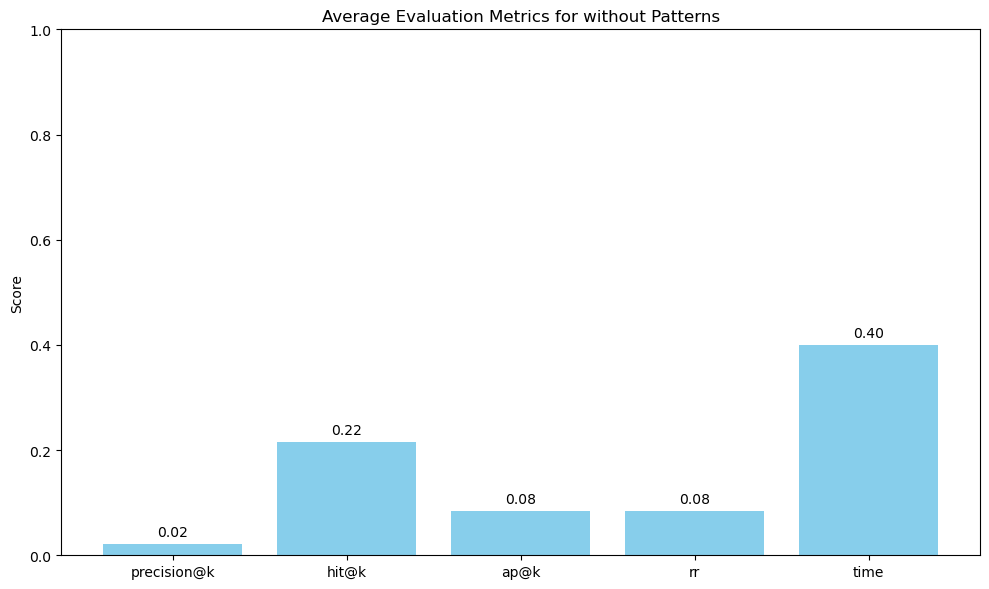

In [ ]:
evaluation_no_pattern_df = pd.DataFrame(evaluation_results_no_pattern)
average_scores_no_pattern = evaluation_no_pattern_df[['precision@k', 'hit@k', 'ap@k', 'rr', 'time']].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(average_scores_no_pattern.index, average_scores_no_pattern.values, color='skyblue')
plt.title("Average Evaluation Metrics for Recommendation (without Patterns)")
plt.ylabel("Score")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 5.4 Support and Confidence of Top Patterns on Test Set 

In [30]:
test_df = pd.read_csv('./data/Groceries data test.csv')

# Group items per member
transactions = test_df.groupby('Member_number')['itemDescription'].apply(set).tolist()

# Load top-5 rules from Task 1 output
rules_df = pd.read_csv('./data/rules.csv')
top_5 = rules_df.sort_values(by=['support', 'confidence'], ascending=False).head(5)

# Clean frozenset format
top_5['antecedents'] = top_5['antecedents'].apply(lambda x: set(eval(x)))
top_5['consequents'] = top_5['consequents'].apply(lambda x: set(eval(x)))

# Compute support and confidence on test set
test_supports = []
test_confidences = []

for _, row in top_5.iterrows():
    ant = row['antecedents']
    cons = row['consequents']

    count_ant = sum(ant.issubset(t) for t in transactions)
    count_both = sum(ant.union(cons).issubset(t) for t in transactions)

    support_test = count_both / len(transactions)
    confidence_test = count_both / count_ant if count_ant > 0 else 0

    test_supports.append(support_test)
    test_confidences.append(confidence_test)

# Add to DataFrame
top_5['support_test'] = test_supports
top_5['confidence_test'] = test_confidences

# Display selected columns
top_5[['antecedents', 'consequents', 'support', 'confidence', 'support_test', 'confidence_test']]

,antecedents,consequents,support,confidence,support_test,confidence_test
0,{rolls/buns},{whole milk},0.007913,0.094746,0.028043,0.204082
1,{whole milk},{rolls/buns},0.007913,0.067032,0.028043,0.140449
2,{other vegetables},{whole milk},0.006978,0.075194,0.037297,0.246753
3,{whole milk},{other vegetables},0.006978,0.059110,0.037297,0.186798
4,{yogurt},{whole milk},0.006546,0.101790,0.021873,0.203655


#### 5.5 Sample Recommendations for Top Frequent Patterns

The following code generates 10 example recommendations using the 5 most frequent pattern rules. For each rule 2 different members are selected from the test set and recommendations are made using the integrated system.

In [31]:
output_rows = []
for idx, row in top_5.iterrows():
    antecedent = list(row['antecedents'])
    consequent = list(row['consequents'])
    matching_users = test_df[test_df['itemDescription'].isin(antecedent)]

    for members_id in matching_users['Member_number'].unique()[:2]:
        recommendations = recommender.recommend(members_id, top_k=5, is_pattern_used=True)
        recommended_items = [item for item, _ in recommendations]
        output_rows.append([antecedent, consequent, recommended_items])

# Convert to DataFrame
df_output = pd.DataFrame(output_rows, columns=["Antecedent", "Consequent", "Recommendations"])
pd.set_option('display.max_colwidth', None)
display(df_output)

,Antecedent,Consequent,Recommendations
0,[rolls/buns],[whole milk],"[bags, other vegetables, rolls/buns, soda, yogurt]"
1,[rolls/buns],[whole milk],"[whole milk, yogurt, other vegetables, root vegetables, pastry]"
2,[whole milk],[rolls/buns],"[flower (seeds), citrus fruit, instant coffee, canned beer, bottled water]"
3,[whole milk],[rolls/buns],"[baby cosmetics, bags, citrus fruit, condensed milk, bottled water]"
4,[other vegetables],[whole milk],"[citrus fruit, hard cheese, canned beer, bottled water, cake bar]"
5,[other vegetables],[whole milk],"[rolls/buns, whole milk, yogurt, other vegetables, potato products]"
6,[whole milk],[other vegetables],"[flower (seeds), citrus fruit, instant coffee, canned beer, bottled water]"
7,[whole milk],[other vegetables],"[baby cosmetics, bags, citrus fruit, condensed milk, bottled water]"
8,[yogurt],[whole milk],"[whole milk, yogurt, soda, rolls/buns, potato products]"
9,[yogurt],[whole milk],"[soda, other vegetables, pastry, pip fruit, preservation products]"


### 6. Final System

In [32]:
class RecommendationSystem:
    def __init__(self, cf_model, pattern_file: str):
        """
        Initialize the hybrid recommendation system.

        :param cf_model: Instance of CollaborativeFiltering class
        :param pattern_file: Path to CSV file with pattern mining rules (Task 1 output)
        """
        self.cf_model = cf_model
        self.pattern_file = pattern_file

    def recommend(self, member_number, top_k=10, is_pattern_used=True):
        """
        Combine collaborative filtering and pattern mining results using weighted scoring.

        :param member_number: Member number (user ID)
        :param top_k: Number of recommendations to return
        :return: List of (item, score) tuples
        """

        if member_number not in self.cf_model.member_id_to_np_index_map:
            print(f"[Cold Start] User {member_number} is new. Recommending top-{top_k} popular items.")
            return self.cf_model.cold_start(top_k)
        
        # Get collaborative filtering recommendations
        cf_recs = self.cf_model.make_recommendation(member_number, top_k)
        cf_dict = dict(cf_recs)

        if not is_pattern_used:
            # If pattern mining is not used, return CF results directly
            sorted_cf = sorted(cf_dict.items(), key=lambda x: x[1], reverse=True)
            return sorted_cf[:top_k]
        
        # Pattern mining recommendations
        pattern_recs = self.cf_model.make_recommendation_from_pattern(
            self.pattern_file, member_number, top_k
        )
        pattern_dict = dict(pattern_recs)

        # Normalize and combine
        combined_scores = {}
        max_cf = max(cf_dict.values()) if cf_dict else 1
        max_pat = max(pattern_dict.values()) if pattern_dict else 1

        for item, score in cf_dict.items():
            combined_scores[item] = combined_scores.get(item, 0) + (score / max_cf) * 0.7

        for item, score in pattern_dict.items():
            combined_scores[item] = combined_scores.get(item, 0) + (score / max_pat) * 0.3

        sorted_recs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:top_k]
    
# Initialize paths
data_path = './data/Groceries data train.csv'
pattern_path = './data/rules.csv'

# Initialize the system
cf_model = CollaborativeFiltering(data=data_path)
recommender = RecommendationSystem(cf_model=cf_model, pattern_file=pattern_path)

# Take user input
member_input = input("Enter Member Number: ")
if not member_input.isdigit():
    raise ValueError("Member ID must be an integer.")
member_number = int(member_input)

pattern_choice = input("Use frequent patterns? (yes/no): ").strip().lower()
use_patterns = pattern_choice in ["yes", "y"]

print(f"Generating recommendations for Member ID: {member_number} ({'using' if use_patterns else 'not using'} frequent patterns)")
print("-" * 100)
recommendations = recommender.recommend(member_number, top_k=10, is_pattern_used=use_patterns)
for idx, (item, score) in enumerate(recommendations, 1):
    print(f"{idx}. {item:20}")

Generating recommendations for Member ID: 3625 (not using frequent patterns)
----------------------------------------------------------------------------------------------------
1. yogurt              
2. soda                
3. rolls/buns          
4. flower (seeds)      
5. sausage             
6. citrus fruit        
7. pastry              
8. root vegetables     
9. instant coffee      
10. newspapers          


### 7. References

1. Lee, C.-H. ., Kim, Y.-H. . and Rhee, P.-K. . (2001). Web personalization expert with combining collaborative filtering and association rule mining technique. Expert Systems with Applications, 21(3), pp.131–137. <<https://doi.org/10.1016/s0957-4174(01)00034-3>>
2. S. Parvatikar and B. Joshi, "Online book recommendation system by using collaborative filtering and association mining," 2015 IEEE International Conference on Computational Intelligence and Computing Research (ICCIC), Madurai, India, 2015, pp. 1-4. <<https://doi.org/10.1109/ICCIC.2015.7435717>>
3. Zhou, T., Kuscsik, Z., Liu, J.-G. ., Medo, M., Wakeling, J.R. and Zhang, Y.-C. . (2010). Solving the apparent diversity-accuracy dilemma of recommender systems. Proceedings of the National Academy of Sciences, 107(10), pp.4511–4515. <<https://doi.org/10.1073/pnas.1000488107>>
4. 10 metrics to evaluate recommender and ranking systems n.d., <<https://www.evidentlyai.com/ranking-metrics/evaluating-recommender-systems>>
5. Kyasar (2023) 'Recommender Systems: What Long-Tail Tells', Medium, 5 May. Available at: https://medium.com/@kyasar.mail/recommender-systems-what-long-tail-tells-91680f10a5b2 (Accessed: 27 May 2025).